<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Duels_Quality_Score_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q openpyxl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# === LOAD DATA ===
input_path = '/content/drive/My Drive/Database March 2025/Australia 2024-2025.xlsx'
df = pd.read_excel(input_path, sheet_name=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# === FILTER FOR CFs WITH MINIMUM 500 MINUTES PLAYED ===
df['Position'] = df['Position'].astype(str).str.strip()  # Clean whitespaces
df = df[df['Minutes played'] >= 500]
df = df[df['Position'].str.contains('CF', na=False)]

# === FILTER RELEVANT COLUMNS ===
relevant_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in [
    'aerial', 'defensive', 'foul', 'card'])]
model_data = df[['Player', 'Team'] + relevant_cols].copy()

# Show how many missing values in each relevant column
print("Missing values in relevant columns:\n", model_data[relevant_cols].isna().sum())

# Drop rows with missing values only in columns used for scoring
cols_to_scale = [
    'Defensive duels per 90', 'Defensive duels won, %',
    'Aerial duels per 90', 'Aerial duels won, %',
    'Fouls per 90', 'Yellow cards per 90', 'Red cards per 90'
]
model_data.dropna(subset=cols_to_scale, inplace=True)

# === NORMALIZE METRICS ===
scaler = MinMaxScaler()
model_data[cols_to_scale] = scaler.fit_transform(model_data[cols_to_scale])

# === CALCULATE DUELS QUALITY SCORE ===
model_data['Duels Quality Score'] = (
    0.25 * model_data['Defensive duels per 90'] +
    0.25 * model_data['Defensive duels won, %'] +
    0.25 * model_data['Aerial duels per 90'] +
    0.25 * model_data['Aerial duels won, %'] -
    0.20 * model_data['Fouls per 90'] -
    0.15 * model_data['Yellow cards per 90'] -
    0.30 * model_data['Red cards per 90']
)

# === ADD POSITION FROM ORIGINAL DATA ===
model_data = model_data.merge(df[['Player', 'Position']], on='Player', how='left')

# === EXPECTED SCORES ===
# By Position
pos_avg = model_data.groupby('Position')['Duels Quality Score'].mean().reset_index()
pos_avg.columns = ['Position', 'Expected Positional Score']
model_data = model_data.merge(pos_avg, on='Position', how='left')
model_data['Over Position Avg'] = model_data['Duels Quality Score'] - model_data['Expected Positional Score']

# By Team
team_avg = model_data.groupby('Team')['Duels Quality Score'].mean().reset_index()
team_avg.columns = ['Team', 'Team Avg Score']
model_data = model_data.merge(team_avg, on='Team', how='left')
model_data['Over Team Avg'] = model_data['Duels Quality Score'] - model_data['Team Avg Score']

# === PREDICT NEXT MATCH SCORE ===
model_data['Predicted Next Match Score'] = (
    0.5 * model_data['Duels Quality Score'] +
    0.3 * model_data['Team Avg Score'] +
    0.2 * model_data['Expected Positional Score']
)

# === SAVE RESULT TO GOOGLE DRIVE ===
output_path = '/content/drive/My Drive/Duels_Quality_Predictions_CF.xlsx'
model_data.to_excel(output_path, index=False)
print("✅ File saved to:", output_path)

Filtered CF players: 48
            Player    Position  Minutes played
5      Mikael Doka  CF, RW, LW            2038
18  K. Barbarouses          CF            1925
20      A. Taggart          CF            1900
25          G. May          CF            1871
34      H. Ibusuki          CF            1805
Missing values in relevant columns:
 Successful defensive actions per 90     0
Defensive duels per 90                  0
Defensive duels won, %                  0
Aerial duels per 90                     0
Aerial duels won, %                     0
Fouls per 90                            0
Yellow cards                            0
Yellow cards per 90                     0
Red cards                               0
Red cards per 90                        0
Fouls suffered per 90                   0
Aerial duels per 90.1                  48
dtype: int64
✅ File saved to: /content/drive/My Drive/Duels_Quality_Predictions_CF.xlsx


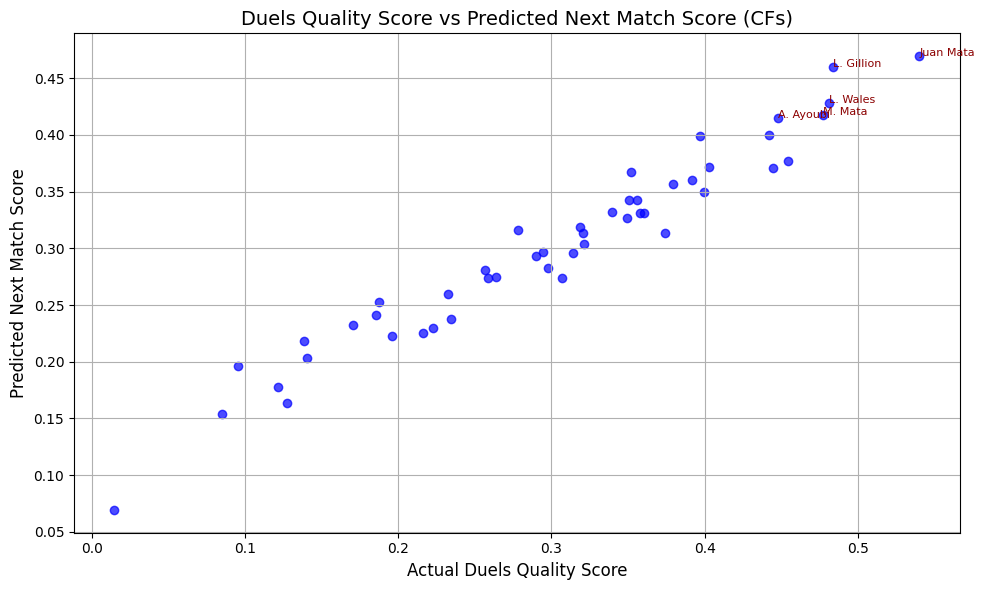

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load the Excel file ===
file_path = '/content/drive/My Drive/Duels_Quality_Predictions_CF.xlsx'  # adjust if needed
df = pd.read_excel(file_path)

# === Scatter Plot: Duels Quality Score vs Predicted Next Match Score ===
plt.figure(figsize=(10, 6))
plt.scatter(df['Duels Quality Score'], df['Predicted Next Match Score'], alpha=0.7, color='blue')

# Titles and labels
plt.title('Duels Quality Score vs Predicted Next Match Score (CFs)', fontsize=14)
plt.xlabel('Actual Duels Quality Score', fontsize=12)
plt.ylabel('Predicted Next Match Score', fontsize=12)
plt.grid(True)

# Annotate top 5 predicted players
top_players = df.sort_values('Predicted Next Match Score', ascending=False).head(5)
for _, row in top_players.iterrows():
    plt.text(row['Duels Quality Score'], row['Predicted Next Match Score'],
             row['Player'], fontsize=8, color='darkred')

plt.tight_layout()
plt.show()


In [10]:
from scipy.stats import median_abs_deviation

# Calculate median and MAD
median = df['Duels Quality Score'].median()
mad = median_abs_deviation(df['Duels Quality Score'], scale='normal')

# Compute robust z-scores
df['Robust Z-Score'] = 0.6745 * (df['Duels Quality Score'] - median) / mad
df

,Player,Team,Successful defensive actions per 90,Defensive duels per 90,"Defensive duels won, %",Aerial duels per 90,"Aerial duels won, %",Fouls per 90,Yellow cards,Yellow cards per 90,...,Fouls suffered per 90,Aerial duels per 90.1,Duels Quality Score,Position,Expected Positional Score,Over Position Avg,Team Avg Score,Over Team Avg,Predicted Next Match Score,Robust Z-Score
0,Mikael Doka,Central Coast Mariners,4.77,0.403685,0.722927,0.098150,0.627378,0.216216,3,0.185714,...,1.28,NaN,0.391935,"CF, RW, LW",0.391935,0.000000,0.285382,0.106553,0.359969,0.414190
1,K. Barbarouses,Wellington Phoenix,4.21,0.554439,0.385363,0.109413,0.254044,0.681081,2,0.128571,...,0.89,NaN,0.170313,CF,0.287857,-0.117544,0.297883,-0.127571,0.232093,-0.804430
2,A. Taggart,Perth Glory,2.75,0.120603,0.371083,0.255833,0.438400,0.459459,2,0.128571,...,0.71,NaN,0.185302,CF,0.287857,-0.102555,0.303004,-0.117702,0.241124,-0.722009
3,G. May,Auckland FC,4.91,0.520938,0.522213,0.473049,0.791644,0.675676,0,0.000000,...,1.20,NaN,0.441826,CF,0.287857,0.153969,0.404895,0.036931,0.399953,0.688526
4,H. Ibusuki,Western United,3.44,0.182580,0.562277,0.342719,0.703289,0.486486,0,0.000000,...,1.00,NaN,0.350419,CF,0.287857,0.062562,0.364818,-0.014399,0.342226,0.185910
5,B. Borrello,Western Sydney Wanderers,3.91,0.415410,0.239587,0.200322,0.592533,0.881081,4,0.314286,...,1.09,NaN,0.138604,CF,0.287857,-0.149253,0.304624,-0.166020,0.218261,-0.978785
6,V. Germain,Macarthur,2.96,0.192630,0.388933,0.321802,0.638222,0.237838,2,0.157143,...,1.10,NaN,0.314258,CF,0.287857,0.026401,0.270837,0.043421,0.295951,-0.012927
7,S. Mauk,Adelaide United,6.67,0.877722,0.493257,0.139984,0.938311,0.881081,3,0.242857,...,1.57,NaN,0.399674,"AMF, CF",0.242348,0.157326,0.338576,0.061097,0.349879,0.456744
8,J. Lolley,Sydney,4.27,0.194305,0.609084,0.234916,0.873244,0.118919,0,0.000000,...,0.96,NaN,0.454103,"RAMF, CF, LAMF",0.454103,0.000000,0.196823,0.257281,0.376919,0.756034
9,K. Jelacic,Brisbane Roar,7.19,0.891122,0.461127,0.119067,0.401422,0.551351,5,0.400000,...,1.76,NaN,0.297914,"LW, CF, RW",0.297914,0.000000,0.247667,0.050247,0.282840,-0.102795


In [ ]:
df